## 케라스 자동차 연비 예측 모델

- Source : https://www.tensorflow.org/tutorials/keras/regression

### modules import

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
plt.style.use("seaborn-white")
sns.set(style="white")

from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model, get_file
from tensorflow.keras.optimizers.legacy import Adam, RMSprop

/var/folders/79/v97_0rqs3p34z9xx6y57xks80000gn/T/ipykernel_3096/2523510341.py:6: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-white")


### 데이터 로드

In [3]:
dataset_path = get_file("auto-mpg.data", "https://archive.ics.uci.edu/ml/machine-learning-databases/auto-mpg/auto-mpg.data")

In [4]:
columns_names = ["MPG", "Cylinders", "Displacement", "Horsepower", "Weight", "Acceleration", "Model Year", "Origin"]

### 데이터 확인

In [5]:
raw_dataset = pd.read_csv(dataset_path, names=columns_names, na_values="?", comment="\t", sep=" ", skipinitialspace=True)
dataset = raw_dataset.copy()
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,Origin
0,18.0,8,307.0,130.0,3504.0,12.0,70,1
1,15.0,8,350.0,165.0,3693.0,11.5,70,1
2,18.0,8,318.0,150.0,3436.0,11.0,70,1
3,16.0,8,304.0,150.0,3433.0,12.0,70,1
4,17.0,8,302.0,140.0,3449.0,10.5,70,1
...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1
394,44.0,4,97.0,52.0,2130.0,24.6,82,2
395,32.0,4,135.0,84.0,2295.0,11.6,82,1
396,28.0,4,120.0,79.0,2625.0,18.6,82,1


### 데이터 전처리

- 해당 데이터는 일부 데이터가 누락되어 있음

In [6]:
dataset.isna().sum()

MPG             0
Cylinders       0
Displacement    0
Horsepower      6
Weight          0
Acceleration    0
Model Year      0
Origin          0
dtype: int64

- 누락된 행 삭제

In [7]:
dataset = dataset.dropna()

- "Origin" 범주형 데이터
  - 원-핫 인코딩(one-hot encoding) 진행

In [8]:
dataset["Origin"].unique()

array([1, 3, 2])

In [9]:
dataset["USA"] = (dataset.loc[:, "Origin"] == 1) * 1.0
dataset["Eroupe"] = (dataset.loc[:, "Origin"] == 2) * 2.0
dataset["Japan"] = (dataset.loc[:, "Origin"] == 3) * 3.0
dataset = dataset.drop(["Origin"], axis=1)

/var/folders/79/v97_0rqs3p34z9xx6y57xks80000gn/T/ipykernel_3096/3495131105.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["USA"] = (dataset.loc[:, "Origin"] == 1) * 1.0
/var/folders/79/v97_0rqs3p34z9xx6y57xks80000gn/T/ipykernel_3096/3495131105.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dataset["Eroupe"] = (dataset.loc[:, "Origin"] == 2) * 2.0
/var/folders/79/v97_0rqs3p34z9xx6y57xks80000gn/T/ipykernel_3096/3495131105.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy o

In [10]:
dataset

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Eroupe,Japan
0,18.0,8,307.0,130.0,3504.0,12.0,70,1.0,0.0,0.0
1,15.0,8,350.0,165.0,3693.0,11.5,70,1.0,0.0,0.0
2,18.0,8,318.0,150.0,3436.0,11.0,70,1.0,0.0,0.0
3,16.0,8,304.0,150.0,3433.0,12.0,70,1.0,0.0,0.0
4,17.0,8,302.0,140.0,3449.0,10.5,70,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
393,27.0,4,140.0,86.0,2790.0,15.6,82,1.0,0.0,0.0
394,44.0,4,97.0,52.0,2130.0,24.6,82,0.0,2.0,0.0
395,32.0,4,135.0,84.0,2295.0,11.6,82,1.0,0.0,0.0
396,28.0,4,120.0,79.0,2625.0,18.6,82,1.0,0.0,0.0


#### 검증 데이터셋 생성

In [11]:
train_data = dataset.sample(frac=0.8, random_state=0)
test_data = dataset.drop(train_data.index)

In [12]:
test_data

,MPG,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Eroupe,Japan
9,15.0,8,390.0,190.0,3850.0,8.5,70,1.0,0.0,0.0
25,10.0,8,360.0,215.0,4615.0,14.0,70,1.0,0.0,0.0
28,9.0,8,304.0,193.0,4732.0,18.5,70,1.0,0.0,0.0
31,25.0,4,113.0,95.0,2228.0,14.0,71,0.0,0.0,3.0
33,19.0,6,232.0,100.0,2634.0,13.0,71,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...
369,34.0,4,112.0,88.0,2395.0,18.0,82,1.0,0.0,0.0
375,36.0,4,105.0,74.0,1980.0,15.3,82,0.0,2.0,0.0
382,34.0,4,108.0,70.0,2245.0,16.9,82,0.0,0.0,3.0
384,32.0,4,91.0,67.0,1965.0,15.7,82,0.0,0.0,3.0


#### 데이터 조사

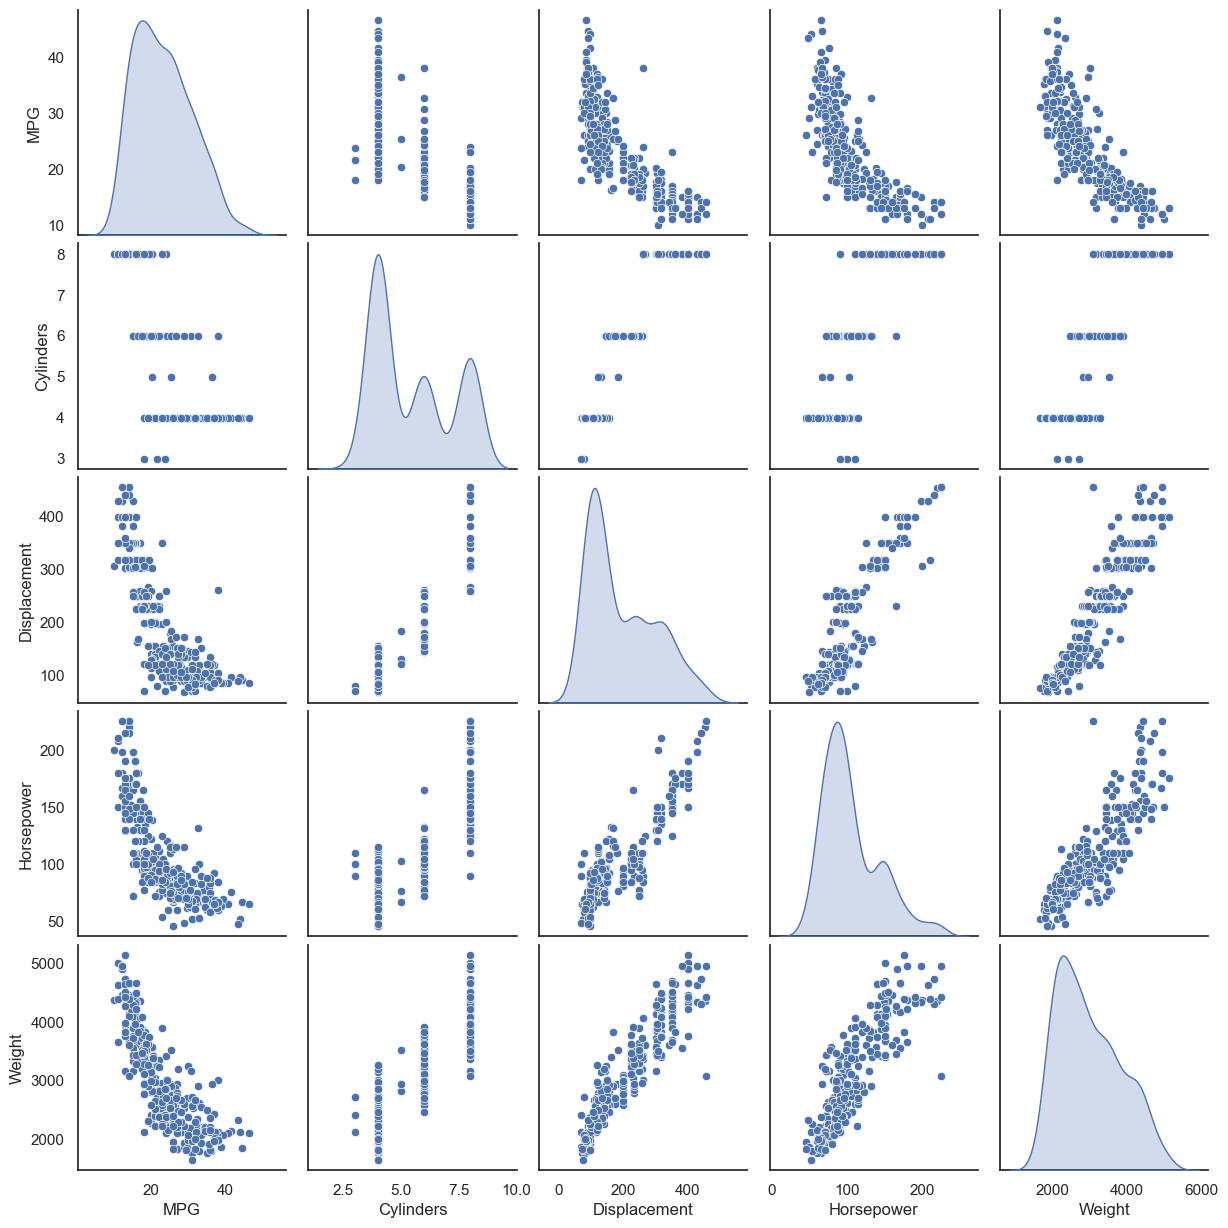

In [13]:
sns.pairplot(train_data[["MPG", "Cylinders", "Displacement", "Horsepower", "Weight"]], diag_kind="kde");

In [14]:
train_stats = train_data.describe()
train_stats = train_stats.drop("MPG", axis=1)
train_stats.transpose()

,count,mean,std,min,25%,50%,75%,max
Cylinders,314.0,5.477707,1.699788,3.0,4.00,4.0,8.00,8.0
Displacement,314.0,195.318471,104.331589,68.0,105.50,151.0,265.75,455.0
Horsepower,314.0,104.869427,38.096214,46.0,76.25,94.5,128.00,225.0
Weight,314.0,2990.251592,843.898596,1649.0,2256.50,2822.5,3608.00,5140.0
Acceleration,314.0,15.559236,2.789230,8.0,13.80,15.5,17.20,24.8
Model Year,314.0,75.898089,3.675642,70.0,73.00,76.0,79.00,82.0
USA,314.0,0.624204,0.485101,0.0,0.00,1.0,1.00,1.0
Eroupe,314.0,0.356688,0.766826,0.0,0.00,0.0,0.00,2.0
Japan,314.0,0.592357,1.196135,0.0,0.00,0.0,0.00,3.0


#### 데이터의 특성과 레이블 분리

In [15]:
train_labels = train_data.pop("MPG")
test_labels = test_data.pop("MPG")

In [16]:
train_labels

146    28.0
282    22.3
69     12.0
378    38.0
331    33.8
       ... 
281    19.8
229    16.0
150    26.0
145    32.0
182    28.0
Name: MPG, Length: 314, dtype: float64

#### 데이터 정규화

In [17]:
def normalization(x):
    return (x - np.mean(x, axis=0)) / (np.std(x, axis=0))

In [18]:
normed_train_data = normalization(train_data)
normed_test_data = normalization(test_data)

In [19]:
normed_train_data

,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Eroupe,Japan
146,-0.870736,-1.011070,-0.785304,-1.026939,-0.380365,-0.517221,0.775913,-0.465891,-0.496016
282,-0.870736,-0.531064,-0.443518,-0.118985,0.625098,0.845257,0.775913,-0.465891,-0.496016
69,1.486256,1.484962,1.449450,1.739650,-0.739460,-1.062212,0.775913,-0.465891,-0.496016
378,-0.870736,-0.867069,-1.100799,-1.026939,-0.308547,1.662743,0.775913,-0.465891,-0.496016
331,-0.870736,-0.943870,-0.995634,-1.003202,0.876464,1.117752,-1.288804,-0.465891,2.016065
...,...,...,...,...,...,...,...,...,...
281,0.307760,0.044943,-0.522392,-0.000299,0.948283,0.845257,0.775913,-0.465891,-0.496016
229,1.486256,1.964968,1.975275,1.459549,-1.601286,0.300266,0.775913,-0.465891,-0.496016
150,-0.870736,-0.838268,-0.312062,-0.711232,-0.021271,-0.517221,-1.288804,-0.465891,2.016065
145,-0.870736,-1.078271,-1.153381,-1.171737,1.235558,-0.517221,-1.288804,-0.465891,2.016065


In [20]:
train_data.shape

(314, 9)

In [21]:
train_data.columns

Index(['Cylinders', 'Displacement', 'Horsepower', 'Weight', 'Acceleration',
       'Model Year', 'USA', 'Eroupe', 'Japan'],
      dtype='object')

### 모델 구성

In [22]:
def build_model():
    input = Input(shape=(len(train_data.columns), ), name="input")
    hidden1 = Dense(64, activation="relu", name="hidden1")(input)
    hidden2 = Dense(64, activation="relu", name="hidden2")(hidden1)
    output = Dense(1, activation="relu", name="output")(hidden2)
    model = Model(inputs=[input], outputs=[output])

    model.compile(optimizer="rmsprop",
                  loss="mse",
                  metrics=["mae", "mse"])
    
    return model

In [23]:
model = build_model()

model.summary()

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 9)]               0         
                                                                 
 hidden1 (Dense)             (None, 64)                640       
                                                                 
 hidden2 (Dense)             (None, 64)                4160      
                                                                 
 output (Dense)              (None, 1)                 65        
                                                                 
Total params: 4,865
Trainable params: 4,865
Non-trainable params: 0
_________________________________________________________________


In [24]:
sample_batch = normed_train_data[:10]
sample_result = model.predict(sample_batch)
sample_batch

1/1 [==============================] - 0s 76ms/step


2023-06-20 09:45:57.335804: W tensorflow/tsl/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


,Cylinders,Displacement,Horsepower,Weight,Acceleration,Model Year,USA,Eroupe,Japan
146,-0.870736,-1.011070,-0.785304,-1.026939,-0.380365,-0.517221,0.775913,-0.465891,-0.496016
282,-0.870736,-0.531064,-0.443518,-0.118985,0.625098,0.845257,0.775913,-0.465891,-0.496016
69,1.486256,1.484962,1.449450,1.739650,-0.739460,-1.062212,0.775913,-0.465891,-0.496016
378,-0.870736,-0.867069,-1.100799,-1.026939,-0.308547,1.662743,0.775913,-0.465891,-0.496016
331,-0.870736,-0.943870,-0.995634,-1.003202,0.876464,1.117752,-1.288804,-0.465891,2.016065
257,0.307760,0.352147,-0.390935,0.260812,0.589189,0.572761,0.775913,-0.465891,-0.496016
310,-0.870736,-1.020670,-1.179672,-1.213278,1.163740,1.117752,-1.288804,-0.465891,2.016065
328,-0.870736,-0.473463,-0.995634,0.308287,2.241022,1.117752,-1.288804,2.146426,-0.496016
125,0.307760,0.025743,-0.259479,0.132631,0.337823,-0.517221,0.775913,-0.465891,-0.496016
108,-0.870736,-0.943870,-0.443518,-0.844162,1.235558,-0.789716,-1.288804,-0.465891,2.016065


In [25]:
plot_model(model, show_shapes=True)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### 모델 학습

In [26]:
model_hist = model.fit(normed_train_data, train_labels,
                       epochs=1000,
                       batch_size=None,
                       validation_split=0.2, verbose=2)


Epoch 1/1000
8/8 - 1s - loss: 554.5825 - mae: 22.2194 - mse: 554.5825 - val_loss: 543.0585 - val_mae: 21.8904 - val_mse: 543.0585 - 677ms/epoch - 85ms/step
Epoch 2/1000
8/8 - 0s - loss: 503.5157 - mae: 20.9858 - mse: 503.5157 - val_loss: 491.3318 - val_mae: 20.6183 - val_mse: 491.3318 - 75ms/epoch - 9ms/step
Epoch 3/1000
8/8 - 0s - loss: 454.9889 - mae: 19.7517 - mse: 454.9889 - val_loss: 435.3414 - val_mae: 19.1688 - val_mse: 435.3414 - 76ms/epoch - 9ms/step
Epoch 4/1000
8/8 - 0s - loss: 402.0705 - mae: 18.3606 - mse: 402.0705 - val_loss: 375.7287 - val_mae: 17.5206 - val_mse: 375.7287 - 76ms/epoch - 9ms/step
Epoch 5/1000
8/8 - 0s - loss: 345.9460 - mae: 16.7581 - mse: 345.9460 - val_loss: 313.2856 - val_mae: 15.7053 - val_mse: 313.2856 - 75ms/epoch - 9ms/step
Epoch 6/1000
8/8 - 0s - loss: 288.5115 - mae: 15.0974 - mse: 288.5115 - val_loss: 253.2373 - val_mae: 13.8769 - val_mse: 253.2373 - 79ms/epoch - 10ms/step
Epoch 7/1000
8/8 - 0s - loss: 232.0408 - mae: 13.3429 - mse: 232.0408 - v

In [27]:
model_hist.history.keys()

dict_keys(['loss', 'mae', 'mse', 'val_loss', 'val_mae', 'val_mse'])

### 모델 학습 시각화

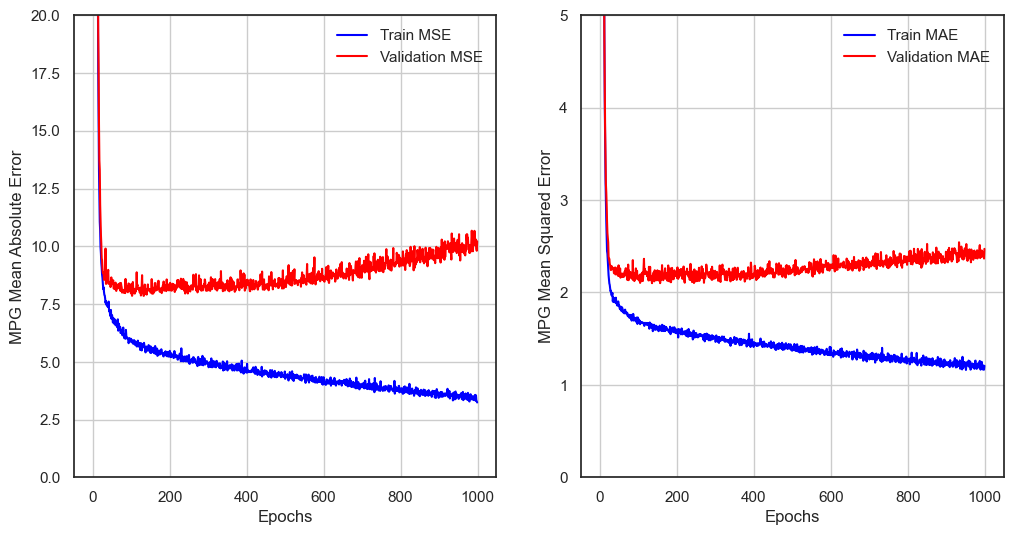

In [28]:
def plot_history(history):
    hist = history.history

    epochs = history.epoch
    train_mse = hist["loss"]
    val_mse = hist["val_loss"]
    train_mae = hist["mae"]
    val_mae = hist["val_mae"]

    plt.figure(figsize=(12, 6))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_mse, color="blue", label="Train MSE")
    plt.plot(epochs, val_mse, color="red", label="Validation MSE")
    plt.xlabel("Epochs")
    plt.ylabel("MPG Mean Absolute Error")
    plt.ylim([0, 20])
    plt.legend()
    plt.grid()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_mae, color="blue", label="Train MAE")
    plt.plot(epochs, val_mae, color="red", label="Validation MAE")
    plt.xlabel("Epochs")
    plt.ylabel("MPG Mean Squared Error")
    plt.ylim([0, 5])
    plt.legend()
    plt.grid()
    plt.show()

plot_history(model_hist)

### EarlyStopping을 이용한 규제화

In [29]:
from tensorflow.keras.callbacks import EarlyStopping

In [30]:
earlystopping = EarlyStopping(monitor="val_loss", patience=10)

model = build_model()

model_hist = model.fit(normed_train_data, train_labels,
                       epochs=1000,
                       validation_split=0.2,
                       callbacks=[earlystopping])

Epoch 1/1000
8/8 [==============================] - 1s 33ms/step - loss: 564.7636 - mae: 22.5024 - mse: 564.7636 - val_loss: 549.6577 - val_mae: 22.1652 - val_mse: 549.6577
Epoch 2/1000
8/8 [==============================] - 0s 13ms/step - loss: 509.1339 - mae: 21.2949 - mse: 509.1339 - val_loss: 492.0633 - val_mae: 20.9074 - val_mse: 492.0633
Epoch 3/1000
8/8 [==============================] - 0s 13ms/step - loss: 455.6842 - mae: 20.0815 - mse: 455.6842 - val_loss: 432.2339 - val_mae: 19.5194 - val_mse: 432.2339
Epoch 4/1000
8/8 [==============================] - 0s 13ms/step - loss: 398.9101 - mae: 18.7206 - mse: 398.9101 - val_loss: 369.7278 - val_mae: 17.9641 - val_mse: 369.7278
Epoch 5/1000
8/8 [==============================] - 0s 12ms/step - loss: 340.1812 - mae: 17.1943 - mse: 340.1812 - val_loss: 305.8370 - val_mae: 16.2063 - val_mse: 305.8370
Epoch 6/1000
8/8 [==============================] - 0s 13ms/step - loss: 279.8814 - mae: 15.4815 - mse: 279.8814 - val_loss: 240.8946 -

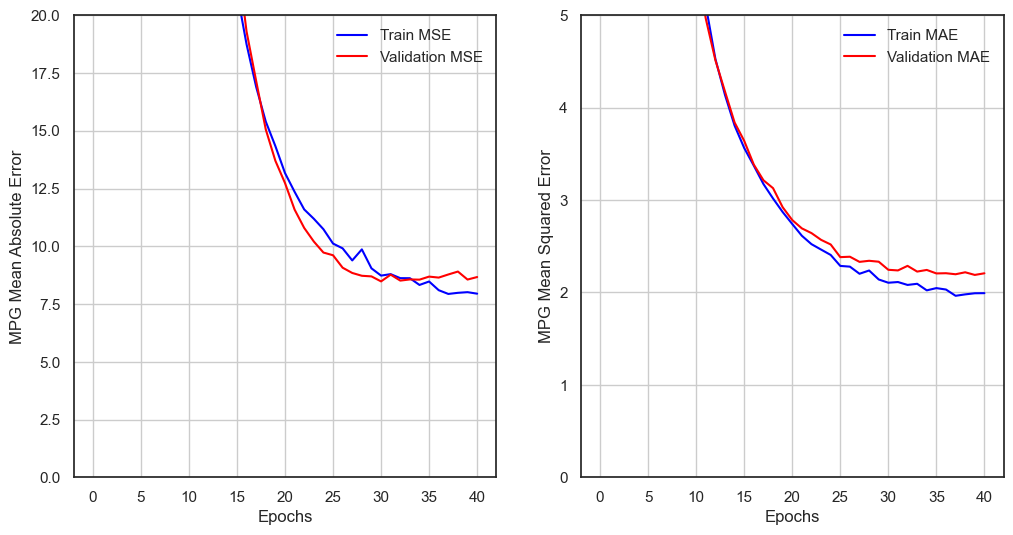

In [31]:
plot_history(model_hist)

### 모델 평가

In [32]:
loss, mse, mae = model.evaluate(normed_test_data, test_labels, verbose=2)

3/3 - 0s - loss: 6.7758 - mae: 1.9373 - mse: 6.7758 - 58ms/epoch - 19ms/step


### 학습된 모델을 통한 예측

3/3 [==============================] - 0s 6ms/step


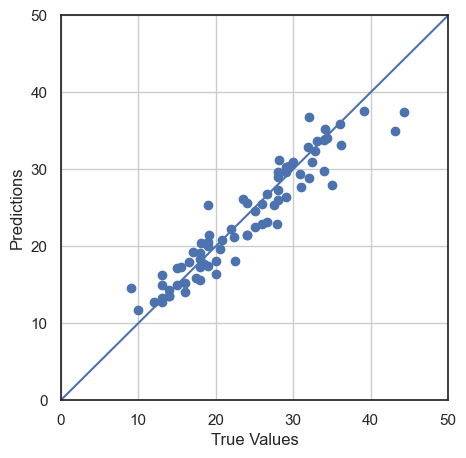

In [33]:
# 예측값 생성
pred_y = model.predict(normed_test_data).flatten()
true_y = test_labels

plt.figure(figsize=(5, 5))

plt.plot([0, 50], [0, 50])
plt.ylim([0, 50])
plt.xlim([0, 50])
plt.scatter(true_y, pred_y)
plt.xlabel("True Values")
plt.ylabel("Predictions")
plt.grid()
plt.show()

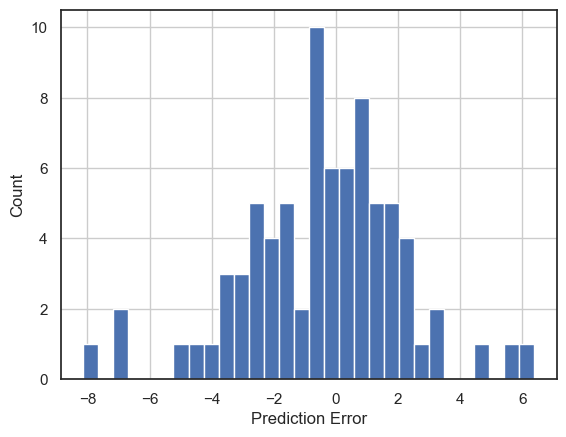

In [34]:
error = pred_y - true_y

plt.hist(error, bins=30)
plt.xlabel("Prediction Error")
plt.ylabel("Count")
plt.grid()
plt.show()